In [44]:
import pyodbc

conn = pyodbc.connect('Driver={SQL Server};'
                      'Server=MSI\\TUONGAN0123;'
                      'Database=DDS_AIR;'
                      'Trusted_Connection=yes;')

cursor = conn.cursor()

In [45]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [56]:
cursor.execute('SELECT FA.AirDataSK, FA.DateSK, FA.StateSK, FA.CountySK, FA.ParameterSK, FA.AQI, FA.Category, FA.DefiningSite, FA.NumberOfSitesReporting, DD.Day, DD.Month, DD.Quarter, DD.Year, DD.Date  FROM Fact_AirQuality FA LEFT JOIN Dim_Date DD ON FA.DateSK = DD.DateSK WHERE (DD.Year <= 2023) AND (DD.Year >= 2021)')
data = cursor.fetchall()

In [57]:
column_name = ['AirDataSK', 'DateSK', 'StateSK', 'CountySK', 'ParameterSK', 'AQI', 'Category', 'DefiningSite', 'NumberOfSitesReporting', 'Day', 'Month', 'Quarter', 'Year', 'Date']
data_list_fact = [list(row) for row in data]
df = pd.DataFrame(data_list_fact, columns=column_name)
df.head(20)
df.to_excel('DataFrame.xlsx')

<strong>1. Chuẩn bị dữ liệu</strong>

In [58]:
# Chuyển đổi Date thành index
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index('Date')

In [59]:
# Tạo series theo ngày với AQI trung bình
daily_aqi = df.groupby('Date')['AQI'].mean()

<strong>2. Vẽ biểu đồ dữ liệu AQI trung bình theo các nhóm thời gian</strong>

<strong> a) Theo ngày</strong>

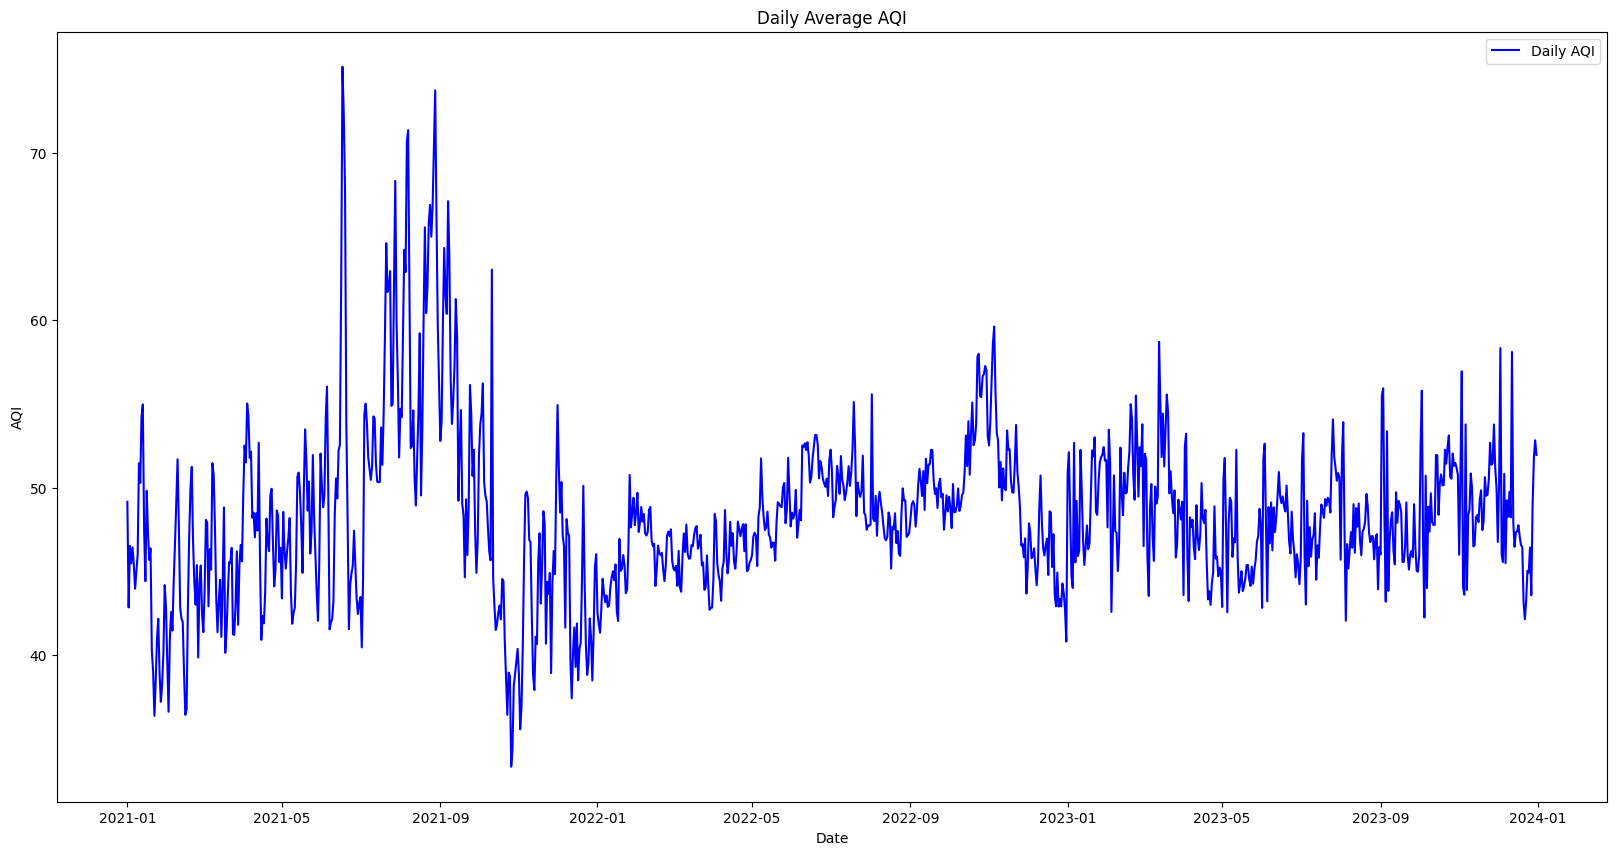

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(daily_aqi.index, daily_aqi, label='Daily AQI', color='blue')
plt.title('Daily Average AQI')
plt.xlabel('Date')
plt.ylabel('AQI')
plt.legend()
plt.show()


<strong>b) Theo tháng</strong>

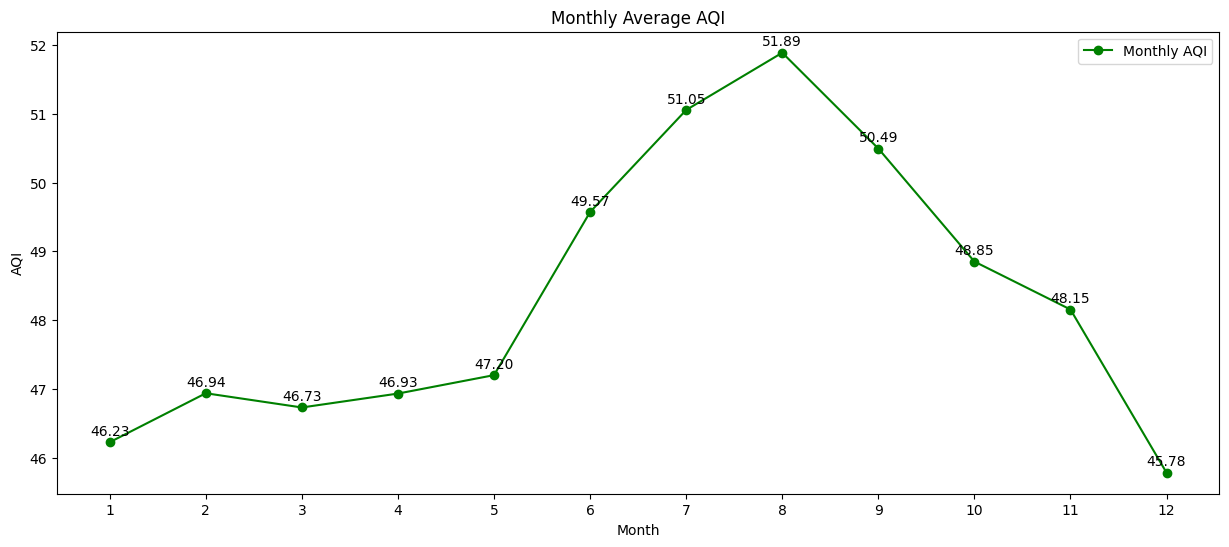

In [90]:
monthly_aqi = df.groupby('Month')['AQI'].mean()
plt.figure(figsize=(15, 6))
plt.plot(monthly_aqi.index, monthly_aqi, label='Monthly AQI', color='green', marker='o')
plt.xticks(ticks=range(1, 13), labels=[str(i) for i in range(1, 13)])
for i, value in enumerate(monthly_aqi):
    plt.text(x=monthly_aqi.index[i], y=value + 0.1, s=f"{value:.2f}", ha='center', fontsize=10)
plt.title('Monthly Average AQI')
plt.xlabel('Month')
plt.ylabel('AQI')
plt.legend()
plt.show()

<strong> c) Theo quý </strong>

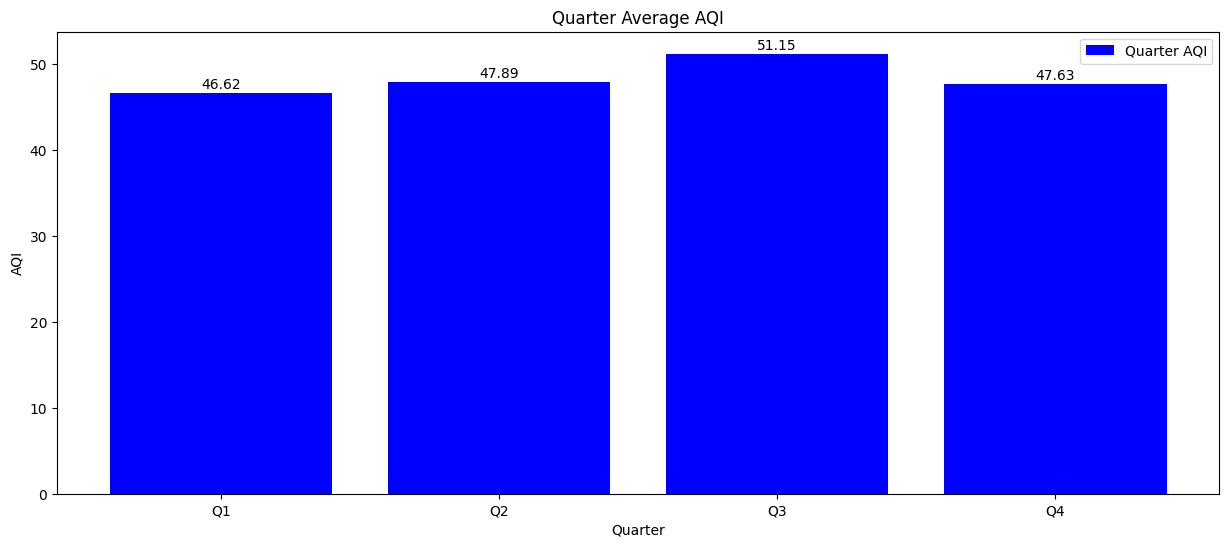

In [91]:
quarter_aqi = df.groupby('Quarter')['AQI'].mean()
plt.figure(figsize=(15, 6))
plt.bar(quarter_aqi.index, quarter_aqi, label='Quarter AQI', color='blue')
plt.xticks(ticks=range(1, 5), labels=['Q1', 'Q2', 'Q3', 'Q4'])
for i, value in enumerate(quarter_aqi):
    plt.text(x=quarter_aqi.index[i], y=value + 0.5, s=f"{value:.2f}", ha='center', fontsize=10)
plt.title('Quarter Average AQI')
plt.xlabel('Quarter')
plt.ylabel('AQI')
plt.legend()
plt.show()

<strong> d) Theo năm </strong>

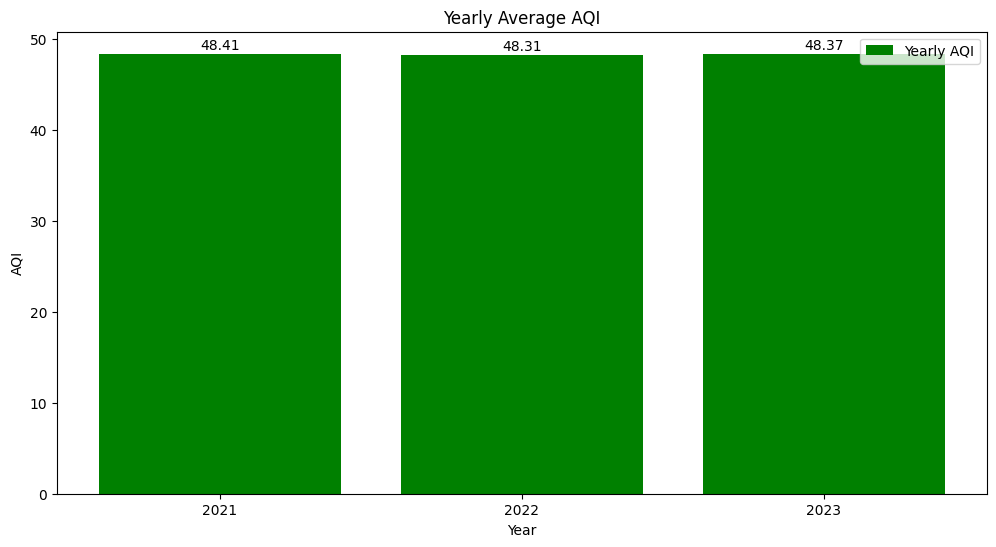

In [85]:
yearly_aqi = df.groupby('Year')['AQI'].mean()

plt.figure(figsize=(12, 6))
plt.bar(yearly_aqi.index, yearly_aqi, label='Yearly AQI', color='green')
plt.xticks(ticks=yearly_aqi.index, labels=yearly_aqi.index)
for i, value in enumerate(yearly_aqi):
    plt.text(x=yearly_aqi.index[i], y=value + 0.5, s=f"{value:.2f}", ha='center', fontsize=10)
plt.title('Yearly Average AQI')
plt.xlabel('Year')
plt.ylabel('AQI')
plt.legend()
plt.show()

<strong>3. Chia tập train/test</strong> <br>
Chia dữ liệu thành 3 phần: <br>
- Train: 2021-2022 (2 năm) <br>
- Val: 2023 Q1-Q3 (9 tháng) <br> 
- Test: 2023 Q4 (3 tháng cuối) <br>

In [113]:
train = daily_aqi['2021-01-01':'2022-12-31']
val = daily_aqi['2023-01-01':'2023-09-30']
test = daily_aqi['2023-10-01':'2023-12-31']

<strong>4. Huấn luyện mô hình SARIMA trên tập train </strong>

In [114]:
train = train.asfreq('D')

model = SARIMAX(train, 
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 12))
results = model.fit()

<strong>5. Dự đoán trên tập validation </strong>

In [115]:
val_forecast = results.predict(start='2023-01-01', end='2023-09-30')

# Đánh giá trên tập test
val_rmse = np.sqrt(mean_squared_error(val, val_forecast))
print(f'Test RMSE: {val_rmse}')

Test RMSE: 5.406538438555035


<strong>6. Dự đoán trên tập test</strong>

In [ ]:
test_forecast = results.predict(start='2023-10-01', end='2023-12-31')

# Đánh giá trên tập test
test_rmse = np.sqrt(mean_squared_error(test, test_forecast))
print(f'Test RMSE: {test_rmse}')

Test RMSE: 7.251893611847774


<strong>7. Visualize kết quả</strong>

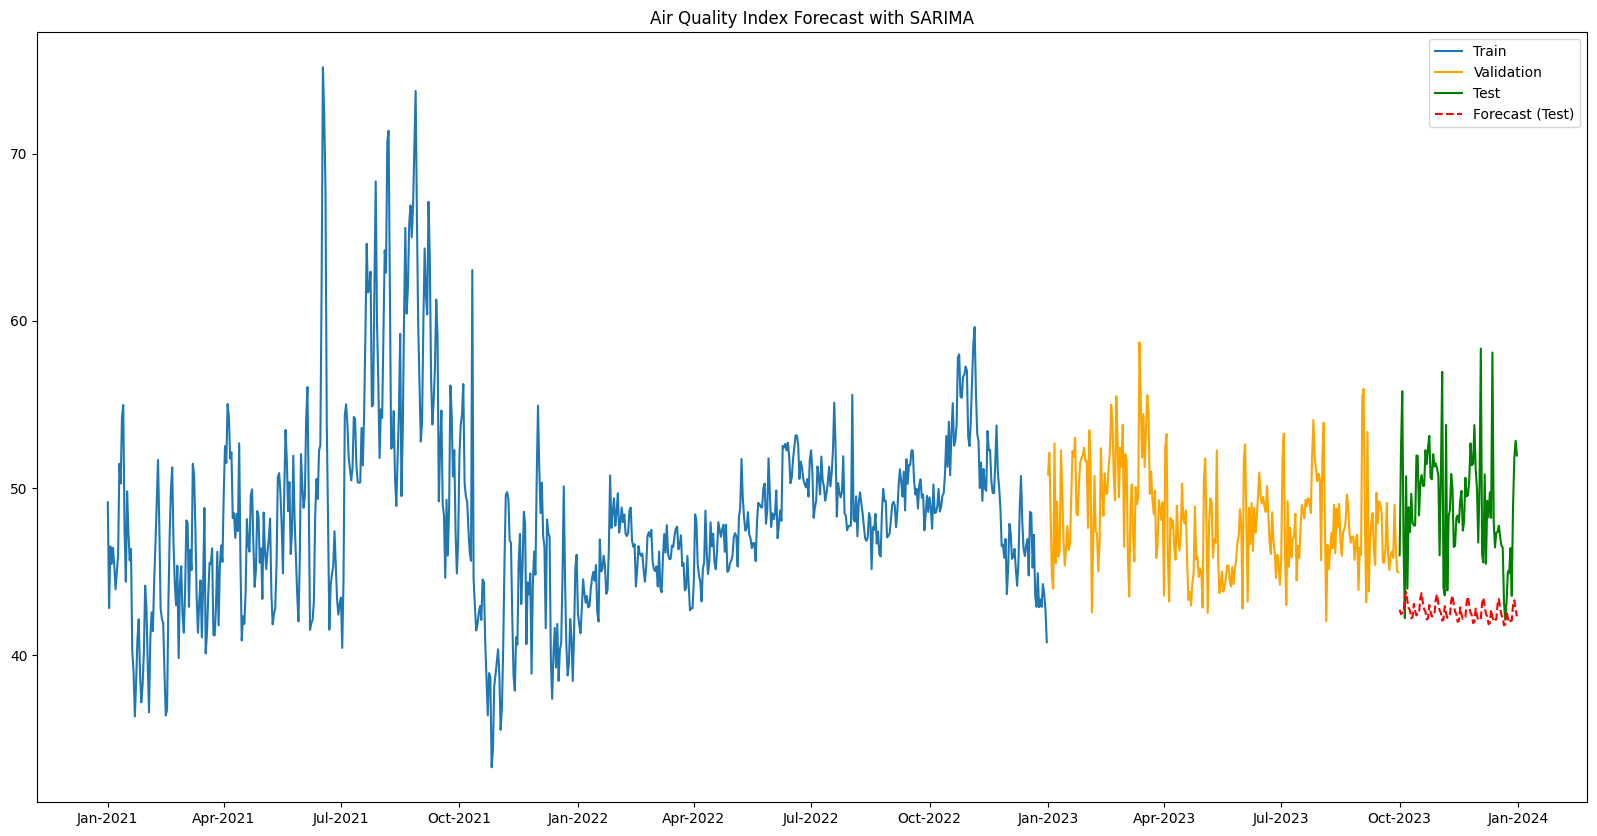

In [119]:
plt.figure(figsize=(20, 10))
plt.plot(train.index, train, label='Train')
plt.plot(val.index, val, label='Validation', color='orange')
plt.plot(test.index, test, label='Test', color='green')
plt.plot(test_forecast.index, test_forecast, label='Forecast (Test)', color='red', linestyle='--')
xticks = pd.date_range(start='2021-01-01', end='2024-01-31', freq='QS')
plt.xticks(xticks, labels=[date.strftime('%b-%Y') for date in xticks])
plt.title('Air Quality Index Forecast with SARIMA')
plt.legend()
plt.show()


Từ đồ thị trên, có thể rút ra một số kết luận về dự đoán AQI cho Q1-2024:<br>

* Xu hướng dự đoán: <br>
    - Giá trị AQI được dự đoán sẽ dao động ổn định ở mức khoảng 42-43 <br>
    - Đường dự đoán (màu đỏ đứt nét) khá phẳng và không thể hiện nhiều biến động <br>


* So sánh với dữ liệu lịch sử: <br>
    - Giá trị dự đoán thấp hơn đáng kể so với thực tế Q4-2023 (đường màu xanh lá cây) có AQI dao động 45-58 <br>
    - Không phản ánh được tính chu kỳ/mùa vụ như dữ liệu trong quá khứ <br>


* Đánh giá độ tin cậy: <br>
    - Model có vẻ chưa nắm bắt tốt tính biến động của dữ liệu <br>
    - Dự đoán khá bảo thủ khi đưa ra giá trị ổn định <br>

* Cần cải thiện model bằng cách: <br>
    - Thêm các biến môi trường khác <br>
    - Xem xét sử dụng mô hình phức tạp hơn để nắm bắt tốt hơn các pattern <br>